# Optimization with CVXPy


In [1]:
%pylab inline
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
from utils import img_utils

Populating the interactive namespace from numpy and matplotlib


In [12]:
reload(img_utils)

<module 'utils.img_utils' from 'utils/img_utils.py'>

## Load DMRI image

/user/lgomez/home/anaconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

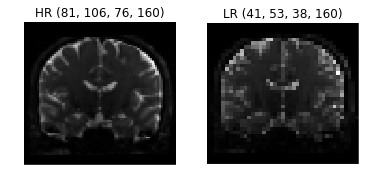

In [2]:
from utils.DataGetter import DataGetter
from utils.DownsampledImage import DownsampledImage

d = DataGetter()
datas_names = [
    DataGetter.STANDFORD_HARDI_DATA, #(81, 106, 76, 160)
    #DataGetter.TAIWAN_NTU_DSI_DATA,  #(96, 96, 60, 203)
    #DataGetter.SHERBROOKE_3SHELL_DATA #(128, 128, 60, 193)
]

scale=2
datas = d.get_data(datas_names)
name = datas_names[0]
lr_hr_img = DownsampledImage(name, datas[name]['img'], datas[name]['gtab'], scale)

img_hr = lr_hr_img.get_hr_img()
img_lr = lr_hr_img.get_lr_img()
img_utils._isc(img_hr,img_lr, titles=['HR '+str(img_hr.shape), 'LR '+str(img_lr.shape)] )

### Select Area of Interest

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

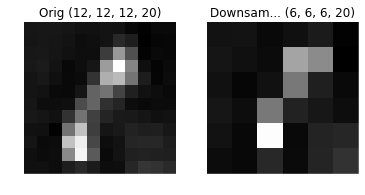

In [3]:
img_shape = img_lr.shape
volume_range_lr = (10, 16, 15, 21, 15, 21)
bval_range = (0,20)

i_lr = img_lr[10:16, 15:21, 15:21,0:20]
i_hr = img_hr[20:32, 30:42, 30:42,0:20]
img_utils._isc(i_hr,i_lr, titles=['Orig '+str(i_hr.shape), 'Downsam... '+str(i_lr.shape)] )

## Problem definition

$ \min_{Y_{hr}} \{ ||GY_{lr} - Y_{hr}||^2 \}$ st $Y_{hr} \geq 0$

In [15]:
Nx, Ny, Nz, bval = i_hr.shape
vhr = Nx*Ny*Nz
vlr = vhr/8

Yhr = cvx.Variable(vhr, bval)
Ylr = i_lr.reshape((vlr, bval))
G_rala = img_utils.buildDownsamplig((Nx, Ny, Nz), 2)
G = cvx.Parameter(*G_rala.shape, value=G_rala)

# Form objective.
obj = cvx.Minimize(cvx.sum_squares(G*Yhr- Ylr))

# Create two constraints.
constraints = [Yhr >= 0]

# Form and solve problem.
prob = cvx.Problem(obj, constraints)
prob

Problem(Minimize(Expression(CONVEX, POSITIVE, (1, 1))), [LeqConstraint(Constant(CONSTANT, ZERO, (1, 1)), Variable(1728, 6))])

In [16]:
prob.solve()  # Returns the optimal value.
print "status:", prob.status
print "optimal value", prob.value
#print "optimal var", Yhr.value

status: optimal_inaccurate
optimal value 1.01741316027e-08


shape= (12, 12, 12, 6)


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

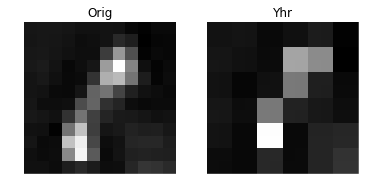

In [17]:
A = np.asarray(Yhr.value).reshape(i_hr.shape)
print 'shape=',A.shape
img_utils._isc(i_hr,A,titles=['Orig', 'Yhr'] )

# Predicting the G downsampling Matrix

In [12]:
reload(rr)
reload(sc)
reload(db)
reload(ixs)
import utils.dmri_patch_operations.DmriPatch as patchs
reload(patchs)

<module 'utils.dmri_patch_operations.DmriPatch' from 'utils/dmri_patch_operations/DmriPatch.pyc'>

In [4]:
import utils.RandomRanges as rr
import utils.DmriVolumesRandomIndexers as ixs
import utils.DmriSampleCreators as sc
import utils.ml.MLDataBuilder as db


# Estrategia de volumne y rango de bvals (fija)
volume_strategy, bval_strategy = rr.Fixed3DRange(*volume_range_lr), rr.Fixed1DRange(*bval_range)
# El que combina ambas
dmri_volume_indexer = ixs.DmriVolumeRandomIndexer(volume_strategy, bval_strategy)
# Equivalencia entre indices de la hr y lr 
fconvert = lambda *lr_tuple : tuple(np.array(lr_tuple[:-2])*2)+lr_tuple[-2:]
# Iterador de dmri imagen lr y hr
lr_hr_vol_it = ixs.DmriLrHrCubicPatchVolumeRandomIndexer(dmri_volume_indexer, fconvert, from_lr2hr=True)

# El que toma la imagen original y downsampleada y les pone ruido (gaussian, rician)
sample_creator = sc.NoisedLrHrDmriSampleCreator(lr_hr_img, lr_hr_vol_it, snr=100, noise_type='gaussian')


n_samples = 10

# Builder that organize data like the ML wants 
sdb = db.SimpleMlDataBuilder(sample_creator, n_samples)

X, Y = sdb.build()
print X.shape, Y.shape

Samples for  standfor_hardi : 10 of inf
(4320, 10) (34560, 10)


In [36]:
from sklearn import linear_model
linear_model.LinearRegression?

In [38]:
from scipy.sparse import csr_matrix, csc_matrix
import experimento1_funciones as e1f
reload(e1f)

print Y.shape
regr, X_train , y_train, X_test, y_test = e1f.train(Y[:,:5],X[:,:5])

(34560, 10)
Training set_training.shape= (34560, 4)  ->target.shape= (4320, 4)


In [55]:
y_pred = regr.predict(i_hr.reshape(-1))

/user/lgomez/home/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [56]:
y_pred.ptp(), y_test.ptp()

(2896.3794012487474, 3197.0)

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

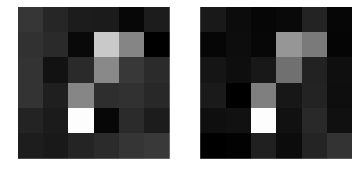

In [57]:
y_pred_mat = y_pred.reshape(i_lr.shape)
img_utils._isc(y_test.reshape(i_lr.shape), y_pred_mat)

In [ ]:
regr.coef_ = csr_matrix(regr.coef_)
type(regr.coef_)

(6, 6, 6, 20)

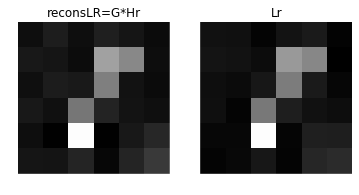

In [58]:
i_lr_recons = regr.coef_.dot(i_hr.reshape(-1)).reshape(i_lr.shape)
img_utils._isc(i_lr_recons, i_lr, titles=['reconsLR=G*Hr','Lr'], b=1)
i_lr_recons.shape

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

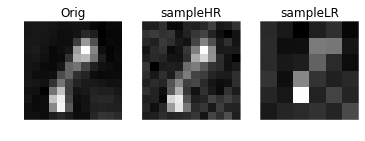

In [59]:
img_utils._isc3(i_hr, Y[:,3].reshape(i_hr.shape),X[:,3].reshape(i_lr.shape), titles=['Orig','sampleHR','sampleLR'] )

(array([   3.,   11.,   74.,  306.,  633.,  701.,  319.,   92.,   19.,    2.]),
 array([-67.19298487, -53.88210478, -40.57122469, -27.26034459,
        -13.9494645 ,  -0.63858441,  12.67229568,  25.98317577,
         39.29405587,  52.60493596,  65.91581605]),
 <a list of 10 Patch objects>)

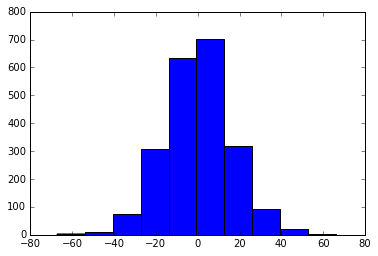

In [18]:
hist(i_lr_recons.flatten())

(array([ 691.,  372.,   49.,   27.,   51.,   54.,   25.,    9.,    6.,   12.]),
 array([  322. ,   586.6,   851.2,  1115.8,  1380.4,  1645. ,  1909.6,
         2174.2,  2438.8,  2703.4,  2968. ]),
 <a list of 10 Patch objects>)

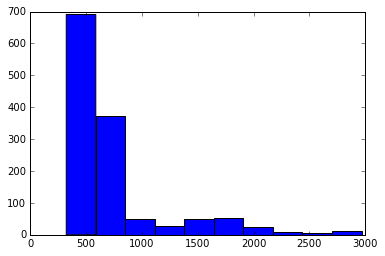

In [10]:
hist(i_lr.flatten())